# Leveraging SMILES notation for rapid and accurate toxicity screening
### *Project in Natural Language Processing (LTAT.01.001)*

### Authors: Ida Rahu and Andri Hõbemägi

In [234]:
# All the needed imports

import SmilesPE
from SmilesPE.pretokenizer import atomwise_tokenizer
import codecs
from SmilesPE.tokenizer import *
SPE_vocabulary = codecs.open('SPE_ChEMBL.txt')
tokenizer_SPE = SPE_Tokenizer(SPE_vocabulary)

import pandas as pd
import glob
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from datasets import Dataset, DatasetDict
from itertools import chain
import warnings
warnings.filterwarnings('ignore')

import torchtext
import torch
from torch import nn, Tensor, optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

## Preprocessing the datasets

### Cleaning and splitting the data

Reading the training (training + validation) and testing datasets into the Pandas DataFrames and checking the datasets by calculating the number of active (`1`), inactive (`0`) and inconclusive (missing; `NaN`) compounds per toxicity assay.

In [145]:
# Function for combining the 12 different .smiles files into one dataframe
def smiles_files2dataframe(folder):
    smiles_files = sorted(glob.glob(f'./{folder}/*.smiles'))
    combined_df = pd.DataFrame()
    for file in smiles_files:
        file_name = file.split('/')[-1].split('.')[0]
        assay_data = pd.read_csv(file, header=None, names=['SMILES', 'ID', 'activity'], sep='\t')
        assay_data = assay_data.rename(columns={'activity': file_name})
        if len(combined_df) == 0:
            combined_df = assay_data
        else:
            combined_df = combined_df.merge(assay_data, left_on=['SMILES', 'ID'], right_on=['SMILES', 'ID'], how='outer')
    return combined_df

In [146]:
training_data_raw = smiles_files2dataframe('Training_data')
testing_data_raw = smiles_files2dataframe('Evaluation_data')

In [147]:
# Checking the raw training (and validation) dataset
summary_stat_train_raw = training_data_raw.loc[:, ~training_data_raw.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_train_raw 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,7219,8296,8982,6866,8307,6760,7962,6069,8753,7722,6178,8097
NaN,3595,3165,2402,4538,3011,4067,3580,4597,2673,3614,4444,3130
1.0,950,303,380,360,446,937,222,1098,338,428,1142,537


In [148]:
# Checking the raw testing dataset
summary_stat_test_raw = testing_data_raw.loc[:, ~testing_data_raw.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_test_raw 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,537,574,574,489,580,465,574,462,584,588,483,575
1.0,73,8,12,39,20,51,31,93,38,22,60,41
NaN,37,65,61,119,47,131,42,92,25,37,104,31


Standardising the SMILES notations to make sure, that each compound occurs only once in the dataset (one compound can have more than one valid SMILES notation).

In [149]:
# Standardising SMILES notations in both datasets - otherwise one compound can have multiple SMILES
training_data_raw = training_data_raw.SMILES.apply(lambda x: rdMolStandardize.StandardizeSmiles(x))
testing_data_raw = testing_data_raw.SMILES.apply(lambda x: rdMolStandardize.StandardizeSmiles(x))

[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Normalizer
[16:17:37] Initializing MetalDisconnector
[16:17:37] Running MetalDisconnector
[16:17:37] Initializing Normalizer
[16:17:37] Running Nor

AtomValenceException: Explicit valence for atom # 3 Si, 8, is greater than permitted

Handling the duplicates in both datasets and after that writing the obtained cleaned datasets into separate files.

In [150]:
# Selecting the duplicates and unique compounds in training dataset
duplicates = training_data_raw[training_data_raw.SMILES.duplicated(keep=False)].sort_values('SMILES')
unique = training_data_raw[-training_data_raw.SMILES.duplicated(keep=False)].sort_values('SMILES')

# Selecting the duplicates and unique compounds in testing dataset
duplicates_test = testing_data_raw[testing_data_raw.SMILES.duplicated(keep=False)].sort_values('SMILES')
unique_test = testing_data_raw[-testing_data_raw.SMILES.duplicated(keep=False)].sort_values('SMILES')

In [151]:
# Handling the duplicates based on the following rules:
# 1. if any of the duplicate rows have a value of "1" for a particular assay, 
# the compound is classified as active in that assay in the combined dataset;

# 2. if at least one of the duplicated rows has a value of "0" for a particular assay while the others have missing values, 
# the compound is classified as inactive in that assay in the combined dataset;

# 3. if all the duplicated rows have a value of "NA" for a particular assay, 
# the compound is marked as inconclusive for that assay in the combined dataset. 

unique_duplicates = duplicates.drop_duplicates(['SMILES'], keep='first').reset_index(drop=True)
for i in range(len(unique_duplicates)):
    smiles = unique_duplicates.iloc[i]['SMILES']
    dup2summary = duplicates[duplicates['SMILES'] == smiles]
    for j in range(2,14):
        new_val = np.max(dup2summary.iloc[:,j])   
        unique_duplicates.iloc[i,j] = new_val

# Combining the previously selected unique compounds and modified duplicated compounds to get the final training set
training_data = pd.concat([unique, unique_duplicates], axis=0).reset_index(drop=True)

# Checking the training dataset
summary_stat_train = training_data.loc[:, ~training_data.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_train 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,5930,6689,7158,5655,6781,5535,6418,4990,6989,6238,5000,6500
NaN,1327,1116,575,2077,905,1709,1436,2084,787,1426,2102,1112
1.0,786,238,310,311,357,799,189,969,267,379,941,431


In [152]:
# Doing the same with the testing dataset
unique_duplicates_test = duplicates_test.drop_duplicates(['SMILES'], keep='first').reset_index(drop=True)
for i in range(len(unique_duplicates_test)):
    smiles = unique_duplicates_test.iloc[i]['SMILES']
    dup2summary = duplicates_test[duplicates_test['SMILES'] == smiles]
    for j in range(2,14):
        new_val = np.max(dup2summary.iloc[:,j])   
        unique_duplicates_test.iloc[i,j] = new_val

testing_data = pd.concat([unique_test, unique_duplicates_test], axis=0).reset_index(drop=True)

summary_stat_test = testing_data.loc[:, ~testing_data.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_test 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,536,573,573,489,579,465,573,461,583,587,483,574
1.0,73,8,12,39,20,51,31,93,38,22,60,41
NaN,37,65,61,118,47,130,42,92,25,37,103,31


In [153]:
# Writing the training and testing datasets into the files
training_data.to_csv('training_data.tsv', sep='\t', index=False)
testing_data.to_csv('testing_data.tsv', sep='\t', index=False)

In [2]:
# Reading in the training and testing datasets - if needed
training_data = pd.read_csv('training_data.tsv', sep='\t')
testing_data = pd.read_csv('testing_data.tsv', sep='\t')

Generating the training and validation datasets by splitting the original dataset (80/20) and removing the missing labels.
Also removing the missing labels from testing datasets.
Using the data from `nr-ahr` and `nr-er` assays because the first was one of the best-predicted assays in the Tox21 Data Challenge, and the second was one of the worst-predicted assays.

In [154]:
train_df, validation_df = train_test_split(training_data, test_size=0.2, random_state=888)

train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [155]:
# nr-ahr 
train_ahr = train_df.dropna(subset=['nr-ahr'])[['SMILES', 'nr-ahr']].reset_index(drop=True)
validation_ahr = validation_df.dropna(subset=['nr-ahr'])[['SMILES', 'nr-ahr']].reset_index(drop=True)

test_ahr = testing_data.dropna(subset=['nr-ahr'])[['SMILES', 'nr-ahr']].reset_index(drop=True)

In [156]:
# nr-er 
train_er = train_df.dropna(subset=['nr-er'])[['SMILES', 'nr-er']].reset_index(drop=True)
validation_er = validation_df.dropna(subset=['nr-er'])[['SMILES', 'nr-er']].reset_index(drop=True)

test_er = testing_data.dropna(subset=['nr-er'])[['SMILES', 'nr-er']].reset_index(drop=True)

In [157]:
# Writing all the datasets to relevant files
train_ahr.to_csv('train_ahr.tsv', sep='\t', index=False)
validation_ahr.to_csv('validation_ahr.tsv', sep='\t', index=False)
test_ahr.to_csv('test_ahr.tsv', sep='\t', index=False)

train_er.to_csv('train_er.tsv', sep='\t', index=False)
validation_er.to_csv('validation_er.tsv', sep='\t', index=False)
test_er.to_csv('test_er.tsv', sep='\t', index=False)

In [158]:
# Calculating the statistics about data and visualising it

# nr-ahr
perc_act_train_ahr = (train_ahr['nr-ahr'].sum() / len(train_ahr['nr-ahr'])) * 100
perc_act_valid_ahr = (validation_ahr['nr-ahr'].sum() / len(validation_ahr['nr-ahr'])) * 100
perc_act_test_ahr = (test_ahr['nr-ahr'].sum() / len(test_ahr['nr-ahr'])) * 100

# Print the percentage
print('Percentage of active compounds in nr-ahr datasets')
print(f"train set: {perc_act_train_ahr:.2f}%")
print(f"validation set: {perc_act_valid_ahr:.2f}%")
print(f"test set: {perc_act_test_ahr:.2f}%")
print('_____________________________________________________________')
# nr-er
perc_act_train_er = (train_er['nr-er'].sum() / len(train_er['nr-er'])) * 100
perc_act_valid_er = (validation_er['nr-er'].sum() / len(validation_er['nr-er'])) * 100
perc_act_test_er = (test_er['nr-er'].sum() / len(test_er['nr-er'])) * 100

# Print the percentage
print('Percentage of active compounds in nr-er datasets')
print(f"train set: {perc_act_train_er:.2f}%")
print(f"validation set: {perc_act_valid_er:.2f}%")
print(f"test set: {perc_act_test_er:.2f}%")

Percentage of active compounds in nr-ahr datasets
train set: 11.66%
validation set: 11.89%
test set: 11.99%
_____________________________________________________________
Percentage of active compounds in nr-er datasets
train set: 12.47%
validation set: 13.21%
test set: 9.88%


In [159]:
statistics_df = pd.DataFrame({'assay': ['nr-ahr', 'nr-ahr', 'nr-ahr', 'nr-er', 'nr-er', 'nr-er'],
                              'dataset': ['train', 'validation', 'test', 'train', 'validation', 'test'],
                              'perc_act': [perc_act_train_ahr, perc_act_valid_ahr, perc_act_test_ahr, 
                                           perc_act_train_er, perc_act_valid_er, perc_act_test_er]})

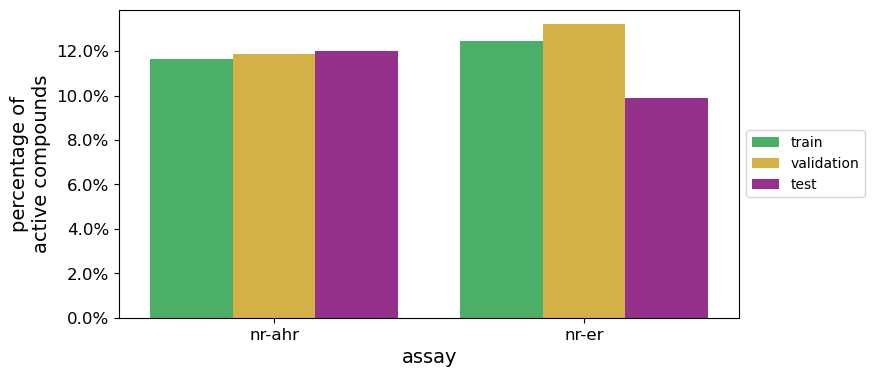

In [160]:
colors_signature = ['#3CBF5F', '#EBBD30', '#A62098']
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=statistics_df, x='assay', y='perc_act', hue='dataset', palette=colors_signature, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax.set_ylabel('percentage of\nactive compounds')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
#plt.savefig('active_perc.png', dpi=700)

### *EXTRA*

Checking also the whole dataset - but will use only the `nr-ahr` and `nr-er` data.

In [122]:
summary_stat_training = train_df.loc[:, ~train_df.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_training 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,4744,5342,5720,4522,5422,4431,5105,3980,5584,4972,3997,5187
NaN,1064,897,464,1662,732,1372,1170,1672,640,1154,1677,894
1.0,626,195,250,250,280,631,159,782,210,308,760,353


In [124]:
summary_stat_validation = validation_df.loc[:, ~validation_df.columns.isin(['SMILES', 'ID'])].apply(pd.value_counts, dropna=False)
summary_stat_validation 

,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53
0.0,1186,1347,1438,1133,1359,1104,1313,1010,1405,1266,1003,1313
NaN,263,219,111,415,173,337,266,412,147,272,425,218
1.0,160,43,60,61,77,168,30,187,57,71,181,78


In [125]:
percentage_of_active_train = (summary_stat_training.iloc[2, :]/(summary_stat_training.iloc[2, :] + summary_stat_training.iloc[0, :])).to_frame()
percentage_of_active_validation = (summary_stat_validation.iloc[2, :]/(summary_stat_validation.iloc[2, :] + summary_stat_validation.iloc[0, :])).to_frame()

In [127]:
percentage_of_active_train['assay'] = percentage_of_active_train.index
percentage_of_active_train = percentage_of_active_train.rename(columns={percentage_of_active_train.columns[0]: 'train'})
percentage_of_active_validation['assay'] = percentage_of_active_validation.index
percentage_of_active_validation = percentage_of_active_validation.rename(columns={percentage_of_active_validation.columns[0]: 'validation'})
total_train_val = percentage_of_active_train.merge(percentage_of_active_validation, left_on='assay', right_on='assay')

In [128]:
total_train_val

,train,assay,validation
0,0.116574,nr-ahr,0.118871
1,0.035218,nr-ar-lbd,0.030935
2,0.041876,nr-ar,0.040053
3,0.052389,nr-aromatase,0.051089
4,0.049106,nr-er-lbd,0.053621
5,0.124654,nr-er,0.132075
6,0.030205,nr-ppar-gamma,0.022338
7,0.164217,sr-are,0.156224
8,0.036244,sr-atad5,0.038988
9,0.058333,sr-hse,0.053104


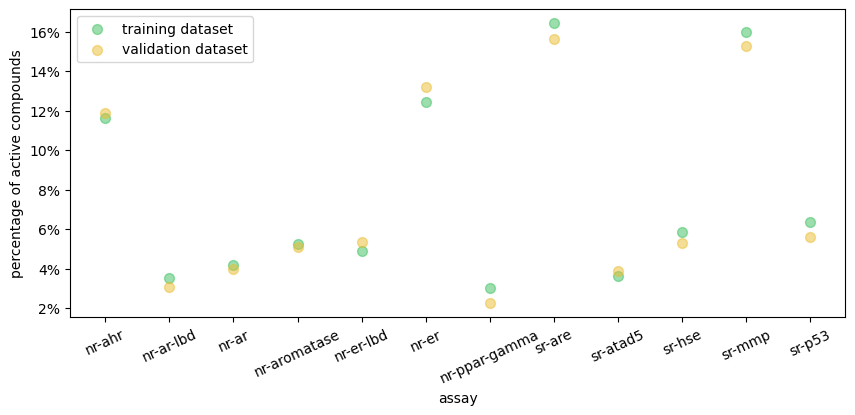

In [129]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(x=total_train_val['assay'], y=total_train_val['train'], color='#3CBF5F', label='training dataset', alpha=0.5, s=50)
ax.scatter(x=total_train_val['assay'], y=total_train_val['validation'], color='#EBBD30', label='validation dataset', alpha=0.5, s=50)
plt.xlabel('assay')
plt.ylabel('percentage of active compounds')
vals = ax.get_yticks()
plt.xticks(rotation = 25)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.legend()
plt.show()

### Preparing the datasets for training the models

Generating the vocabularies by tokenising the SMILES in the training datasets.
Also adding the `<pad>`and `<unk>` tokens.

For tokenisation utilising the pre-trained SmilesPE Tokenizer (https://pypi.org/project/SmilesPE/).

In [161]:
# nr-ahr
unique_tokens_ahr = set(chain(*[tokenizer_SPE.tokenize(SMILES).split(' ') for SMILES in train_ahr['SMILES']]))

vocab_ahr = {key: index for index, key in enumerate(unique_tokens_ahr, start=2)}
vocab_ahr['<pad>'] = 0
vocab_ahr['<unk>'] = 1
id2token_ahr = {value: key for key, value in vocab_ahr.items()}

vocab_ahr_size = len(vocab_ahr)

In [162]:
# nr-er
unique_tokens_er = set(chain(*[tokenizer_SPE.tokenize(SMILES).split(' ') for SMILES in train_er['SMILES']]))

vocab_er = {key: index for index, key in enumerate(unique_tokens_er, start=2)}
vocab_er['<pad>'] = 0
vocab_er['<unk>'] = 1
id2token_er = {value: key for key, value in vocab_er.items()}

vocab_er_size = len(vocab_er)

In [165]:
# Generating Dataset objects
dataset_ahr = DatasetDict({'train': Dataset.from_pandas(train_ahr), 
                           'validation': Dataset.from_pandas(validation_ahr), 
                           'test': Dataset.from_pandas(test_ahr)})

dataset_er = DatasetDict({'train': Dataset.from_pandas(train_er), 
                           'validation': Dataset.from_pandas(validation_er), 
                           'test': Dataset.from_pandas(test_er)})

In [166]:
dataset_ahr

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'nr-ahr'],
        num_rows: 5370
    })
    validation: Dataset({
        features: ['SMILES', 'nr-ahr'],
        num_rows: 1346
    })
    test: Dataset({
        features: ['SMILES', 'nr-ahr'],
        num_rows: 609
    })
})

In [167]:
dataset_er

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'nr-er'],
        num_rows: 5062
    })
    validation: Dataset({
        features: ['SMILES', 'nr-er'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['SMILES', 'nr-er'],
        num_rows: 516
    })
})

Tokenising the SMILES in datasets (if token is not in previously generated vocabulary, then replacing it with `<unk>` token).

In [168]:
# Function for tokenisation
def tokenize_SMILES(data, vocabulary):
    all_tokens = [tokenizer_SPE.tokenize(SMILES).split(' ') for SMILES in data['SMILES']]
    data['tokens'] = [[token if token in vocabulary else '<unk>' for token in token_list] for token_list in all_tokens]
    return data

In [170]:
dataset_ahr = dataset_ahr.map(tokenize_SMILES, batched=True, fn_kwargs={'vocabulary': vocab_ahr})
dataset_er = dataset_er.map(tokenize_SMILES, batched=True, fn_kwargs={'vocabulary': vocab_er})

Map:   0%|          | 0/5370 [00:00<?, ? examples/s]

Map:   0%|          | 0/1346 [00:00<?, ? examples/s]

Map:   0%|          | 0/609 [00:00<?, ? examples/s]

Converting the tokens of the dataset into token IDs by using relevant vocabularies.

In [186]:
# Function for converting tokens into IDs based on vocabulary
def convert2IDs(split, vocabulary, assay):
    return [([vocabulary.get(token) for token in item['tokens']], item[assay]) for item in split]

In [189]:
train_ids_ahr = convert2IDs(dataset_ahr['train'], vocab_ahr, 'nr-ahr')
validation_ids_ahr = convert2IDs(dataset_ahr['validation'], vocab_ahr, 'nr-ahr')
test_ids_ahr = convert2IDs(dataset_ahr['test'], vocab_ahr, 'nr-ahr')

In [190]:
train_ids_er = convert2IDs(dataset_er['train'], vocab_er, 'nr-er')
validation_ids_er = convert2IDs(dataset_er['validation'], vocab_er, 'nr-er')
test_ids_er = convert2IDs(dataset_er['test'], vocab_er, 'nr-er')

Using Dataloader for atomatic batching.

In [192]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the collate function that returns padded smiles tokens (as IDs), 
# labels and length of smiles lists (as Pytorch tensors), and sends them to GPU.
def _collate_fn(batch):
    smiles = [torch.tensor(item[0], dtype=torch.long) for item in batch]
    label_list = [item[1] for item in batch]

    padded_smiles = nn.utils.rnn.pad_sequence(smiles, batch_first=True)
    lengths = torch.tensor([len(item) for item in smiles], dtype=torch.long)
    label_list = torch.tensor(label_list, dtype=torch.float)

    return padded_smiles.to(device), label_list.to(device), lengths.to(device)

In [193]:
# Just checking that everything is correct
dataloader = DataLoader(train_ids_ahr, batch_size=64, shuffle=False, collate_fn=_collate_fn)
smiles_batch, label_batch, length_batch = next(iter(dataloader))
print(smiles_batch)
print(label_batch)
print(length_batch)
print(smiles_batch.shape)

tensor([[ 819,  761,  821,  ...,    0,    0,    0],
        [ 106, 1003,  943,  ...,    0,    0,    0],
        [ 871,  943,  809,  ...,    0,    0,    0],
        ...,
        [ 867,  565,  821,  ...,    0,    0,    0],
        [ 105,  523,    3,  ...,    0,    0,    0],
        [ 809,  617,  481,  ...,    0,    0,    0]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([ 6,  5, 16, 16,  5,  6, 24, 14,  3, 10,  5, 12, 15,  3,  7,  8, 22,  9,
         3,  3,  3,  3, 12,  6, 19, 10, 16, 23,  7,  3, 14, 14, 13, 21, 13, 18,
         3,  6,  4, 14,  6,  4,  3,  3,  3,  2, 34, 17, 10,  5, 14,  6,  4,  7,
        16,  5, 13,  6,  4,  2,  4, 13, 15,  9])
torch.Size([64, 34])


In [194]:
# Selecting batch size 
batch_size = 64  

# Initialising the DataLoader for each dataset split
# nr-ahr
train_dl_ahr = DataLoader(train_ids_ahr, batch_size=batch_size,
                          shuffle=True, collate_fn=_collate_fn)
validation_dl_ahr = DataLoader(validation_ids_ahr, batch_size=batch_size,
                               shuffle=False, collate_fn=_collate_fn)
test_dl_ahr = DataLoader(test_ids_ahr, batch_size=batch_size,
                         shuffle=False, collate_fn=_collate_fn)


train_dl_er = DataLoader(train_ids_er, batch_size=batch_size,
                          shuffle=True, collate_fn=_collate_fn)
validation_dl_er = DataLoader(validation_ids_er, batch_size=batch_size,
                               shuffle=False, collate_fn=_collate_fn)
test_dl_er = DataLoader(test_ids_er, batch_size=batch_size,
                         shuffle=False, collate_fn=_collate_fn)

### Generating the BiLSTM model

In [250]:
class BiLSTM(nn.Module):
    def __init__(self, emb_dim, lstm_hid_dim, class_hid_dim, n_layers, vocab_size):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, #Setting the number of embeddings equal to size of tokens vocabulary (token_vocab_size)
                                      embedding_dim=emb_dim, #Setting embedding size to emb_dim
                                      padding_idx=0) 
        # Bidirectional LSTM layer
        self.bidirectional_LSTM = nn.LSTM(input_size=emb_dim,                               
                                          hidden_size=lstm_hid_dim, #Setting hidden size to hid_dim
                                          num_layers=n_layers, #Setting number of layers to n_layers
                                          batch_first=True,
                                          bidirectional=True) #Setting the bidirectional parameter True (otherwise it would not be bidirectional LSTM)
        # Classification layer
        self.classification = nn.Sequential(nn.Linear(in_features=lstm_hid_dim*2, #Setting the input size of the classification layer to double the size of lstm_hid_dim
                                                      out_features=class_hid_dim),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(in_features=class_hid_dim,
                                                      out_features=1),
                                            nn.Sigmoid()) 
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, tokens, lengths):
        embedded_tokens = self.embedding(tokens) #Encoding the input tokens with the embedding layer
        dropout_tokens = self.dropout(embedded_tokens) #Applying the dropout on the embeddings
        packed_tokens = pack_padded_sequence(input=dropout_tokens, #Packing the embedded inputs with pack_padded_sequence function, with specified parameters
                                            lengths=lengths.cpu(), #Based on documentation: must be on the CPU if provided as a tensor
                                             batch_first=True,
                                             enforce_sorted=False)
        bidirectional_LSTM_output, _  = self.bidirectional_LSTM(packed_tokens) #Passing the packed inputs to the LSTM layer
        _, (hidden, _) = self.bidirectional_LSTM(packed_tokens)
        output = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        predictions = self.classification(output)
        return predictions


Function for training the models.

In [289]:
def model_training(model, num_epochs, train_dl, validation_dl, optimizer, criterion, assay):
    # Loss
    training_loss_list = []
    validation_loss_list = []
    # ROC-AUC
    train_roc_auc_list = []
    validation_roc_auc_list = []
    # Balanced accuracy
    train_balanced_acc_list = []
    validation_balanced_acc_list = []

    best_validation_loss = np.inf
    best_validation_roc_auc = 0
    best_validation_bal_acc = 0
    
    torch.manual_seed(1)
    
    for i in range(num_epochs):
        model.train()
        batches_training_losses = []
        train_labels_list = []
        train_predictions_list = []
    
        for padded_smiles, labels, lengths in train_dl:
            optimizer_ahr.zero_grad()
            predictions = model(padded_smiles, lengths)[:, 0]
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            batches_training_losses.append(loss.item() * labels.size(0))
            train_labels_list.extend(labels.tolist())
            train_predictions_list.extend(predictions.tolist())
    
        training_loss = np.sum(batches_training_losses) / len(train_dl.dataset)
        training_loss_list.append(training_loss)
    
        train_roc_auc = roc_auc_score(train_labels_list, train_predictions_list)
        train_balanced_acc = balanced_accuracy_score(train_labels_list, np.round(train_predictions_list))
        train_roc_auc_list.append(train_roc_auc)
        train_balanced_acc_list.append(train_balanced_acc)
    
        batches_validation_losses = []
        validation_labels_list = []
        validation_predictions_list = []
    
        model.eval()
        with torch.no_grad():
            for padded_smiles, labels, lengths in validation_dl:
                predictions = model(padded_smiles, lengths)[:, 0]
                loss = criterion(predictions, labels)
                batches_validation_losses.append(loss.item() * labels.size(0))
                validation_labels_list.extend(labels.tolist())
                validation_predictions_list.extend(predictions.tolist())
    
        validation_loss = np.sum(batches_validation_losses) / len(validation_dl.dataset)
        validation_loss_list.append(validation_loss)
    
        validation_roc_auc = roc_auc_score(validation_labels_list, validation_predictions_list)
        validation_balanced_acc = balanced_accuracy_score(validation_labels_list, np.round(validation_predictions_list))
    
        validation_roc_auc_list.append(validation_roc_auc)
        validation_balanced_acc_list.append(validation_balanced_acc)
    
        print(f'Epoch {i + 1} >>')
        print(f'LOSS: training = {training_loss:.4f}, validation = {validation_loss:.4f}')
        print(f'ROC-AUC: training  = {train_roc_auc:.4f}, validation = {validation_roc_auc:.4f}')
        print(f'Balanced accuracy: training = {train_balanced_acc:.4f}, validation = {validation_balanced_acc:.4f}')
        
        #Saving the models based on validation loss, ROC-AUC and balanced accuracy
        if validation_loss < best_validation_loss:
            print(f'Validation loss decreased from {best_validation_loss:.4f} to {validation_loss:.4f} >> saving the model.')
            torch.save(model, f'best_model_loss_{assay}_{i}.pt') 
            best_validation_loss = validation_loss
        
        if validation_roc_auc > best_validation_roc_auc:
            print(f'Validation ROC-AUC increased from {best_validation_roc_auc:.4f} to {validation_roc_auc:.4f} >> saving the model.')
            torch.save(model, f'best_model_roc_auc_{assay}_{i}.pt') 
            best_validation_roc_auc = validation_roc_auc
            
        if validation_balanced_acc > best_validation_bal_acc:
            print(f'Validation balanced accuracy increased from {best_validation_bal_acc:.4f} to {validation_balanced_acc:.4f} >> saving the model.')
            torch.save(model, f'best_model_bal_acc_{assay}_{i}.pt')
            best_validation_bal_acc = validation_balanced_acc
        
    return training_loss_list, validation_loss_list, train_roc_auc_list, validation_roc_auc_list, train_balanced_acc_list, validation_balanced_acc_list

### Training the models

**nr-ahr**

In [276]:
# Defining all the needed parameters
config_ahr = dict(
    emb_dim=20, 
    lstm_hid_dim=128, 
    class_hid_dim=64,
    n_layers=1, 
    vocab_size=vocab_ahr_size)

In [277]:
# Initialising the model and sending it to GPU
model_ahr = BiLSTM(**config_ahr)
model_ahr = model_ahr.to(device)
criterion_ahr = nn.BCELoss()
optimizer_ahr = torch.optim.Adam(model_ahr.parameters(), lr=0.001)

In [278]:
model_ahr

BiLSTM(
  (embedding): Embedding(1066, 20, padding_idx=0)
  (bidirectional_LSTM): LSTM(20, 128, batch_first=True, bidirectional=True)
  (classification): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [279]:
train_loss_ahr, validation_loss_ahr, train_roc_auc_ahr, validation_roc_auc_ahr, train_bal_acc_ahr, validation_bal_acc_ahr = model_training(model_ahr, 50, train_dl_ahr, validation_dl_ahr, optimizer_ahr, criterion_ahr, 'ahr')

Epoch 1 >>
LOSS: training = 0.4251, validation = 0.3261
ROC-AUC: training  = 0.5130, validation = 0.7517
Balanced accuracy: training = 0.5000, validation = 0.5000
Validation loss decreased from inf to 0.3261 >> saving the model.
Validation ROC-AUC increased from 0.0000 to 0.7517 >> saving the model.
Validation balanced accuracy increased from 0.0000 to 0.5000 >> saving the model.
Epoch 2 >>
LOSS: training = 0.3386, validation = 0.3178
ROC-AUC: training  = 0.6885, validation = 0.7970
Balanced accuracy: training = 0.5021, validation = 0.5000
Validation loss decreased from 0.3261 to 0.3178 >> saving the model.
Validation ROC-AUC increased from 0.7517 to 0.7970 >> saving the model.
Epoch 3 >>
LOSS: training = 0.3220, validation = 0.3086
ROC-AUC: training  = 0.7408, validation = 0.8131
Balanced accuracy: training = 0.5000, validation = 0.5000
Validation loss decreased from 0.3178 to 0.3086 >> saving the model.
Validation ROC-AUC increased from 0.7970 to 0.8131 >> saving the model.
Epoch 4 >

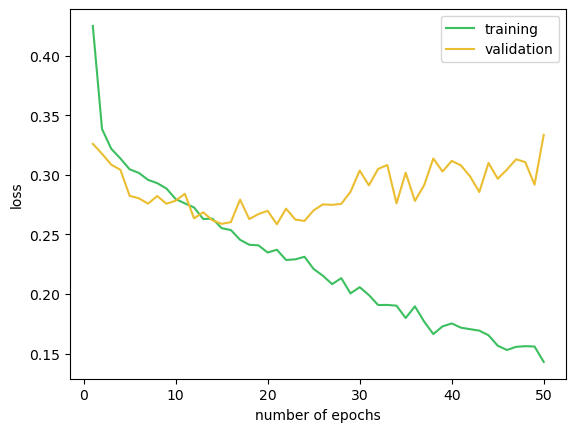

In [284]:
plt.plot(range(1, 51), train_loss_ahr, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_loss_ahr, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

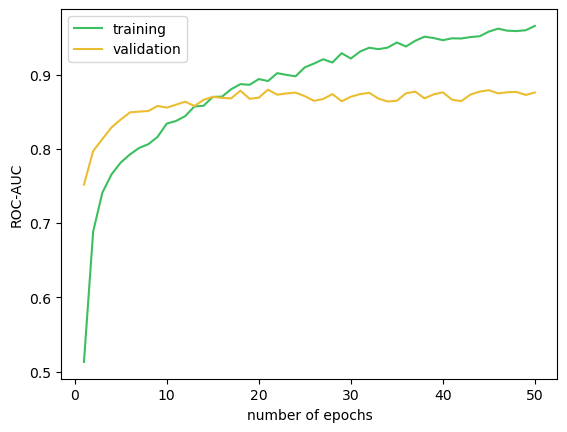

In [285]:
plt.plot(range(1, 51), train_roc_auc_ahr, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_roc_auc_ahr, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

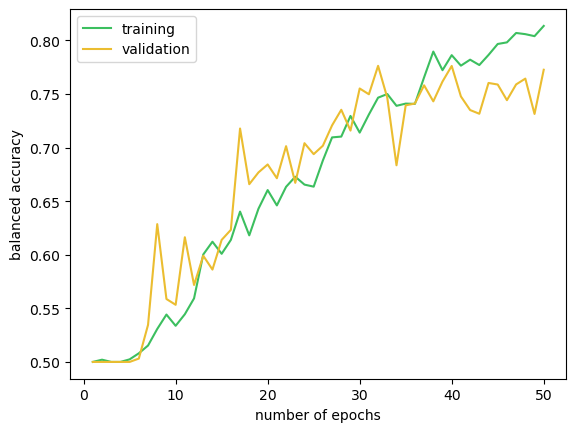

In [288]:
plt.plot(range(1, 51), train_bal_acc_ahr, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_bal_acc_ahr, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('balanced accuracy')
plt.legend()
plt.show()

**nr-er**

In [308]:
# Defining all the needed parameters
config_er = dict(
    emb_dim=300, 
    lstm_hid_dim=128, 
    class_hid_dim=128,
    n_layers=2, 
    vocab_size=vocab_er_size)

In [309]:
# Initialising the model and sending it to GPU
model_er = BiLSTM(**config_er)
model_er = model_er.to(device)
criterion_er = nn.BCELoss()
optimizer_er = torch.optim.Adam(model_er.parameters(), lr=0.001)

In [310]:
model_er

BiLSTM(
  (embedding): Embedding(1057, 300, padding_idx=0)
  (bidirectional_LSTM): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (classification): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [311]:
train_loss_er, validation_loss_er, train_roc_auc_er, validation_roc_auc_er, train_bal_acc_er, validation_bal_acc_er = model_training(model_er, 50, train_dl_er, validation_dl_er, optimizer_er, criterion_er, 'er')

Epoch 1 >>
LOSS: training = 0.5016, validation = 0.4256
ROC-AUC: training  = 0.5396, validation = 0.6503
Balanced accuracy: training = 0.5245, validation = 0.5524
Validation loss decreased from inf to 0.4256 >> saving the model.
Validation ROC-AUC increased from 0.0000 to 0.6503 >> saving the model.
Validation balanced accuracy increased from 0.0000 to 0.5524 >> saving the model.
Epoch 2 >>
LOSS: training = 0.4736, validation = 0.5481
ROC-AUC: training  = 0.5797, validation = 0.6307
Balanced accuracy: training = 0.5447, validation = 0.5787
Validation balanced accuracy increased from 0.5524 to 0.5787 >> saving the model.
Epoch 3 >>
LOSS: training = 0.4599, validation = 0.4741
ROC-AUC: training  = 0.5826, validation = 0.5869
Balanced accuracy: training = 0.5271, validation = 0.5309
Epoch 4 >>
LOSS: training = 0.4294, validation = 0.4517
ROC-AUC: training  = 0.6448, validation = 0.6140
Balanced accuracy: training = 0.5243, validation = 0.5339
Epoch 5 >>
LOSS: training = 0.4011, validation

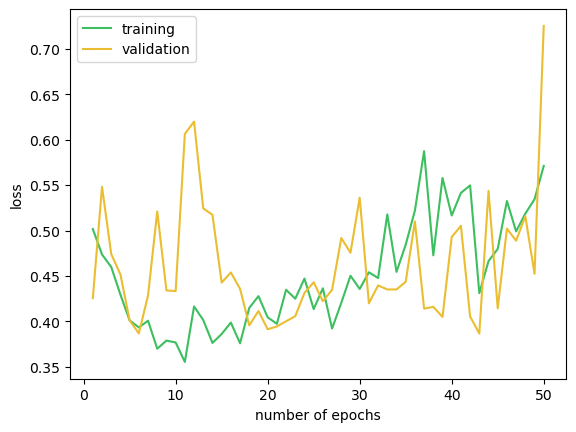

In [312]:
plt.plot(range(1, 51), train_loss_er, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_loss_er, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

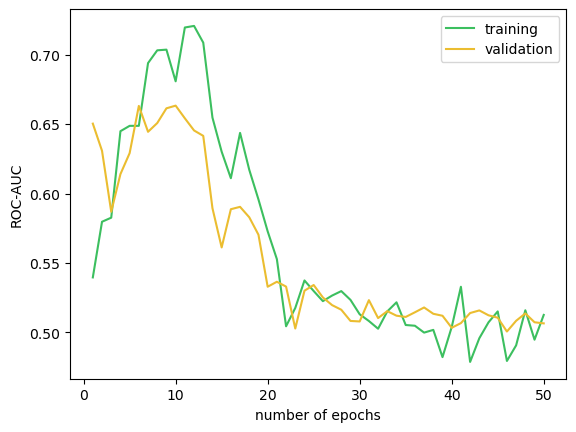

In [313]:
plt.plot(range(1, 51), train_roc_auc_er, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_roc_auc_er, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

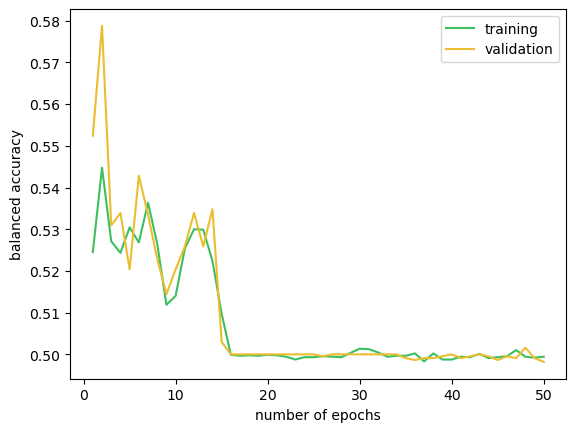

In [314]:
plt.plot(range(1, 51), train_bal_acc_er, label = 'training', color='#3CBF5F')
plt.plot(range(1, 51), validation_bal_acc_er, label = 'validation', color='#EBBD30')
plt.xlabel('number of epochs')
plt.ylabel('balanced accuracy')
plt.legend()
plt.show()

### Testing the models

In [332]:
# Function for the evaluation of the model
def evaluate_model(model, test_dl):
    model.eval()
    test_labels_list = []
    test_predictions_list = []

    with torch.no_grad():
        for padded_smiles, labels, lengths in test_dl:
            predictions = model(padded_smiles, lengths)[:, 0]
            test_labels_list.extend(labels.tolist())
            test_predictions_list.extend(predictions.tolist())

    test_roc_auc = roc_auc_score(test_labels_list, test_predictions_list)
    test_balanced_acc = balanced_accuracy_score(test_labels_list, np.round(test_predictions_list))

    print(f'Test ROC-AUC: {test_roc_auc:.4f}')
    print(f'Test balanced accuracy: {test_balanced_acc:.4f}')

**nr-ahr**

In [328]:
# Based on loss and ROC-AUC the model would be same, so loading only one of them
best_model_loss_ahr = torch.load('best_model_loss_ahr_20.pt')
best_model_bal_acc_ahr = torch.load('best_model_bal_acc_ahr_31.pt')

In [333]:
evaluate_model(best_model_loss_ahr, test_dl_ahr)
evaluate_model(best_model_bal_acc_ahr, test_dl_ahr)

Test ROC-AUC: 0.8271
Test balanced accuracy: 0.6143
Test ROC-AUC: 0.8301
Test balanced accuracy: 0.7196


**nr-er**

In [330]:
best_model_loss_er = torch.load('best_model_loss_er_11.pt')
best_model_roc_auc_er = torch.load('best_model_roc_auc_er_9.pt')
best_model_bal_acc_er = torch.load('best_model_bal_acc_er_1.pt')

In [334]:
evaluate_model(best_model_loss_er, test_dl_er)
evaluate_model(best_model_roc_auc_er, test_dl_er)
evaluate_model(best_model_bal_acc_er, test_dl_er)

Test ROC-AUC: 0.6456
Test balanced accuracy: 0.5000
Test ROC-AUC: 0.6305
Test balanced accuracy: 0.5000
Test ROC-AUC: 0.6371
Test balanced accuracy: 0.5165
